In [41]:
import matplotlib.font_manager
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random 
import csv
from IPython.display import display, Math
from numpy import unravel_index
from astropy.io import fits
from astropy.table import Table
import matplotlib.colors
from scipy.optimize import curve_fit

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

plt.rcParams["font.family"] = "TeX Gyre Schola Math"

print("Quasar Systematics")

Quasar Systematics


## Import the data

### Import the quasars from Gaia in a 7° radius around M31

In [75]:
hdu_list = fits.open('ThisIsTheData/Quasars/Quasars9Deg.fits', memmap=True)
hdu_list.info()
evt_gaia = Table(hdu_list[1].data)
evt_gaia

Filename: ThisIsTheData/Quasars/Quasars9Deg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (733,)   uint8   
  1  /home/svalentin/Documents/S2/Code/Quasar/Gaia_EDR3_AGNs.csv    1 BinTableHDU     26   8087R x 7C   [D, D, E, E, E, E, E]   


RA_ICRS,DE_ICRS,pmRA,e_pmRA,pmDE,e_pmDE,pmRApmDEcor
float64,float64,float32,float32,float32,float32,float32
14.51494996076,33.18963139179,0.446,0.409,-0.131,0.271,0.0966
14.8535384333,33.30587497913,0.165,0.228,0.034,0.169,0.0883
14.78227868691,33.47892550739,0.326,0.465,0.971,0.483,0.2994
15.30408414102,33.56151961951,1.434,0.582,0.136,0.46,0.4056
15.31460375219,33.55830851971,-0.028,0.469,-0.839,0.362,0.2998
15.23190064275,33.58353519805,-0.476,0.54,-0.363,0.513,0.5005
14.94897545436,33.66806426593,-2.523,1.94,1.02,1.434,0.1529
14.98039786701,33.71975260973,-0.415,0.52,0.039,0.378,0.169
15.15954452281,33.75170057371,0.316,0.406,0.371,0.318,0.1822


In [76]:
Delta = 41.27*np.pi/180

evt_gaia['RA_ICRS']  = (evt_gaia['RA_ICRS'] - 10.68)*np.cos(Delta)
evt_gaia['DE_ICRS'] = (evt_gaia['DE_ICRS'] - 41.27)

### Import the data from the model (purely aesthetic)

In [77]:
def OutCVSModel(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3 = [], [], []
    if name != "model":
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append([float(row[0]), float(row[1])])
        return LIST1
    
    else:
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append(float(row[0]))
                LIST2.append(float(row[1]))
                LIST3.append(-float(row[2]))
        return LIST1, LIST2, LIST3        

In [78]:
#Reading the cvs files
x_model, y_model, z_model = OutCVSModel("model")

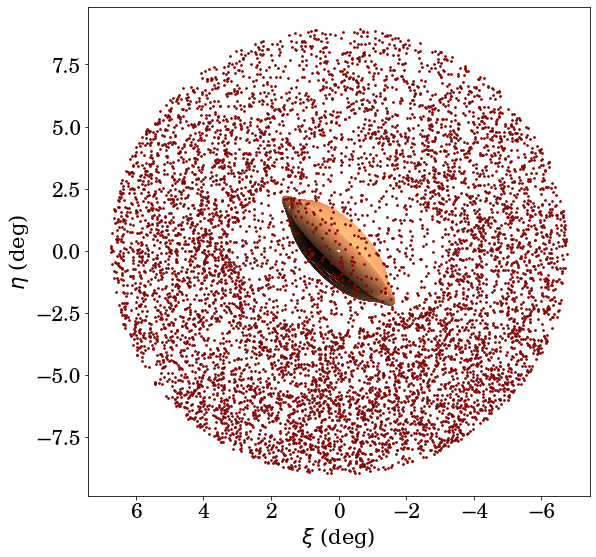

In [79]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)
plt.scatter(evt_gaia['RA_ICRS'], evt_gaia['DE_ICRS'], c='#880808', s=3)

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
#plt.xlim(-2.3, 2.3)
#plt.ylim(-2.3, 2.3)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

### Selection of the different regions

In [8]:
def ElContaminant(RA, DEC, Num): 
    #___ Description_____________________________________________________________________________________
    #Arguments:: This function basically is a simplified function than the one found from 'CleaningCuts' 
    #           It separates the space in 4 quadrant here being N(Num=1), S(Num=2), E(Num=3), W(Num=0). 
    #           RA and DEC position of objects.
    #Returns:: returns either true or false if the object is in one of the four quadrant or not
    #____________________________________________________________________________________________________
    Ra, Dec = np.array(RA), np.array(DEC)
    Result = []
    
    Sign = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
    
    PA     = 45*np.pi/180 #radians, position angle
    
    AngDia2 = 9 #degrees, inclination angle
    A     = AngDia2
    B     = AngDia2
    
    R_rot = np.array([[np.cos(PA), -np.sin(PA)], [np.sin(PA), np.cos(PA)]])
    
    for i in range(len(Ra)):
        Ell_rot = np.dot(R_rot, [Ra[i], Dec[i]])
        if (Ell_rot[0]**2)/(A**2) + (Ell_rot[1]**2)/(B**2) <= 1: #Keeps every stars in the big ellipse
            if Sign[Num][0]*Ell_rot[0]*np.cos(PA) < 0 and Sign[Num][1]*Ell_rot[1]*np.sin(PA) < 0: #Linear selection along lines
                Result.append(True)
            else: 
                Result.append(False)
        else: 
            Result.append(False)

    return Result

In [80]:
def Quadrant(evt_data, Number):
    #___ Description_____________________________________________________________________________________
    #Arguments:: Astropy table in which we find RA and DEC coordinates and a number (see ElContaminant)
    #Returns:: list of the coordinates in the choosen quadrant and also the corresponding pm...
    #____________________________________________________________________________________________________
    mask = (np.array(ElContaminant(evt_gaia['RA_ICRS'], evt_gaia['DE_ICRS'], Number)) == True)
    
    return evt_gaia[mask]['RA_ICRS'], evt_gaia[mask]['DE_ICRS'], evt_gaia[mask]['pmRA'], evt_gaia[mask]['e_pmRA'], evt_gaia[mask]['pmDE'], evt_gaia[mask]['e_pmDE'], evt_gaia[mask]['pmRApmDEcor']

In [82]:
RaDec1 = Quadrant(evt_gaia, 0)
RaDec2 = Quadrant(evt_gaia, 1)
RaDec3 = Quadrant(evt_gaia, 2)
RaDec4 = Quadrant(evt_gaia, 3)

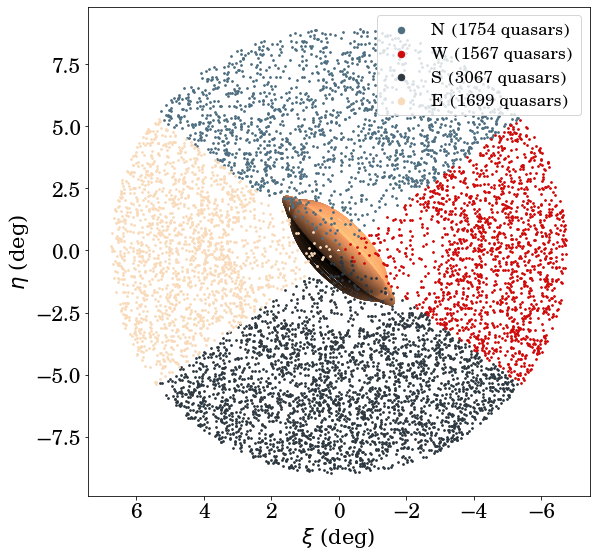

In [83]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)
plt.scatter((RaDec2[0]), (RaDec2[1]), s=3, color='#4E6E81', label=f"N ({len(RaDec2[0])} quasars)")
plt.scatter((RaDec1[0]), (RaDec1[1]), s=3, color='#CF0A0A', label=f"W ({len(RaDec1[0])} quasars)")
plt.scatter((RaDec3[0]), (RaDec3[1]), s=3, color='#2E3840', label=f"S ({len(RaDec3[0])} quasars)")
plt.scatter((RaDec4[0]), (RaDec4[1]), s=3, color='#F9DBBB', label=f"E ({len(RaDec4[0])} quasars)")
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=17)
lgnd.legendHandles[0]._sizes = [42]
lgnd.legendHandles[1]._sizes = [42]
lgnd.legendHandles[2]._sizes = [42]
lgnd.legendHandles[3]._sizes = [42]
plt.show()

### Determine the systematics in each quadrants

Careful, for some reasons that I still can't entirely understand, when saving and returning on the program, all the cells after the cython cells are automatically being deleted. So in order to prevent that, I had to put the cython cells at the end of the program. This is a little annoying because we have first to go at the end to excecute it, but it is necessary.

In [84]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData):
        self.NbModels = NbModels
        
        self.mu_ra      = GaiaData[2]*1000 #convert the proper motions in µas/yr
        self.mu_ra_sig  = GaiaData[3]*1000
        self.mu_dec     = GaiaData[4]*1000
        self.mu_dec_sig = GaiaData[5]*1000
        self.corr       = GaiaData[6]*1000
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_ra_quasars), len(self.pm_dec_quasars)))
        for i in range(len(self.pm_dec_quasars)):
            for j in range(len(self.pm_ra_quasars)):
                for k in range(len(self.mu_ra)):
                    self.LikelihoodList[j,i] += LikelihoodCFunction(self.pm_ra_quasars[i], self.pm_dec_quasars[j], 
                                                                    self.mu_ra_sig[k], self.mu_dec_sig[k], 
                                                                    self.mu_ra[k], self.mu_dec[k])

        self.Renormalisation()  
    
        self.OneDimGaussian()
            
        return self.ra_max, self.dec_max
                
    def FreeParameters(self):
        self.pm_ra_quasars  = np.linspace(-50, 50, self.NbModels) 
        self.pm_dec_quasars = np.linspace(-50, 50, self.NbModels)
        
        self.space = self.pm_ra_quasars[-1] - self.pm_ra_quasars[-2]
        
    def LikelihoodSingleStar(self, index_star, index_model_ra, index_model_dec):
        PreFactor = 1/(2*np.pi*self.mu_ra_sig[index_star]*self.mu_dec_sig[index_star])    
        ExpRa  = -0.5*((self.mu_ra[index_star] - self.pm_ra_quasars[index_model_ra])/(self.mu_ra_sig[index_star]))**2
        ExpDec = -0.5*((self.mu_dec[index_star] - self.pm_dec_quasars[index_model_dec])/(self.mu_dec_sig[index_star]))**2
        
        return np.log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_dec_quasars)):
            for j in range(len(self.pm_ra_quasars)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_quasars[dec_max], self.pm_dec_quasars[ra_max]
        
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
                
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelsize=15, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=15)
            
            ax.contour(self.pm_ra_quasars, self.pm_dec_quasars, self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#ff6200', 'darkred', 'black'])
            ax.scatter(self.ra_max, self.dec_max, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, quasars}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, quasars}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_quasars)):
                self.x_bins.append(self.pm_ra_quasars[i] - self.space/2)
            for i in range(len(self.pm_ra_quasars)):
                self.y_bins.append(self.pm_dec_quasars[i] - self.space/2)
            
            #Plot of the RA histogram
            ax_histx.bar(self.x_bins, self.y_gaus, width=self.space, align='edge', edgecolor='black',
                         color='darkred', alpha=0.7)
            ax_histx.set_yticklabels([])
            self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            ax_histy.barh(self.y_bins, self.x_gaus, height=self.space, align='edge', edgecolor='black',
                          color='darkblue', alpha=0.7)
            ax_histy.set_xticklabels([])
            self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(9, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, quasars} = " + str(round(self.ra_max, 1)) + "\pm" + str(
            round(self.popt_ra[2], 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, quasars} = " + str(round(self.dec_max, 1)) + "\pm" + str(
            round(self.popt_dec[2], 1))  + r"\ \mu as/yr"))

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

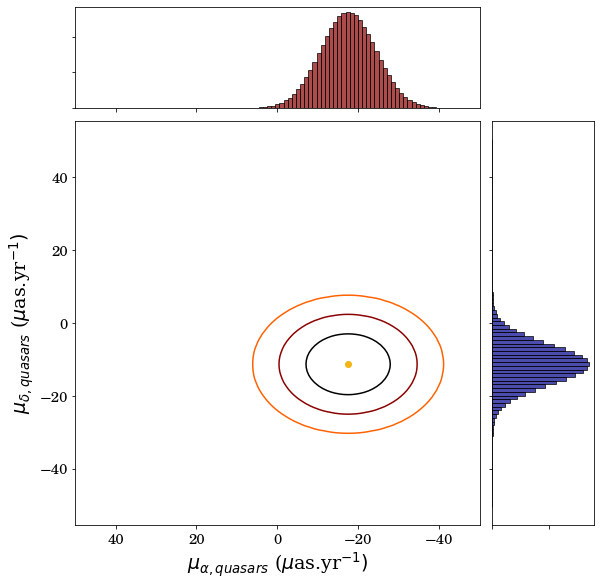

In [85]:
#Western quadrant::
ObjLike = LikelihooD(99, RaDec1)
Answer  = ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

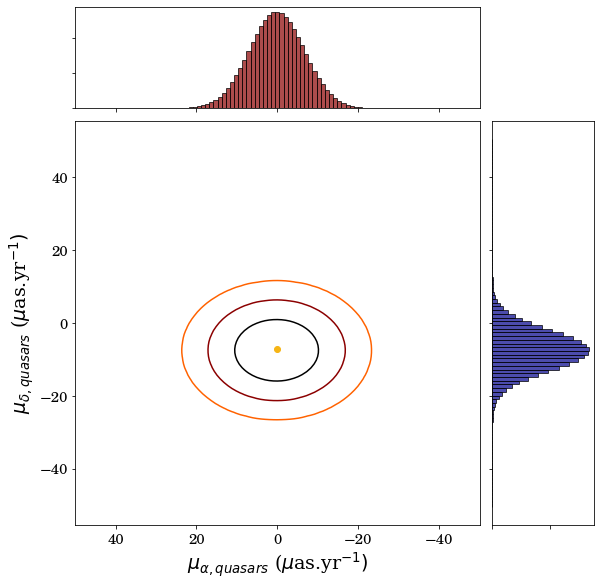

In [16]:
#Northern quadrant::
ObjLike = LikelihooD(99, RaDec2)
Answer  = ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

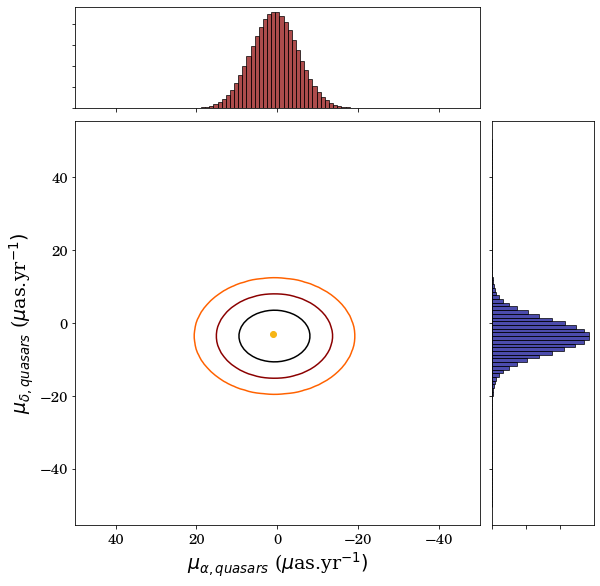

In [17]:
#Southern quadrant::
ObjLike = LikelihooD(99, RaDec3)
Answer  = ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

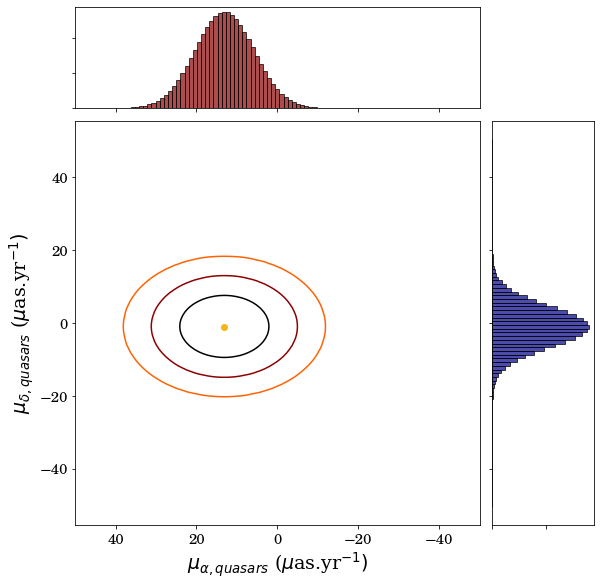

In [18]:
#Eastern quadrant::
ObjLike = LikelihooD(99, RaDec4)
Answer  = ObjLike.Execute()
ObjLike.Plot()

# PS1 Catalogue

## All the objects

In this section we will first visualise all the objects present in the PS1 catalogue and in a radius of 7° around M31 without taking into account any condition on the probability of the object to be a QSO or not.

In [102]:
hdu_list = fits.open('CrossMatchedAll.fits', memmap=True)
hdu_list.info()
evt_all = Table(hdu_list[1].data)

Filename: CrossMatchedAll.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1505,)   uint8   
  1  1xGaia EDR3    1 BinTableHDU     42   70459R x 9C   [D, D, E, D, D, D, D, D, D]   


In [103]:
Delta = 41.27*np.pi/180

evt_all['RAdeg']  = (evt_all['RAdeg'] - 10.68)*np.cos(Delta)
evt_all['DECdeg'] = (evt_all['DECdeg'] - 41.27)

## Cut on the probability

Here we decide to make a cut on the probability of the object being a quasar, we take it superior to 0.5.

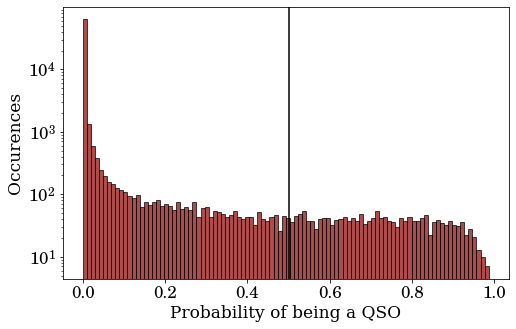

In [105]:
plt.figure(figsize=(8, 5))
plt.hist(evt_all['p_QSO'], bins=100, edgecolor='black', color='darkred', alpha=0.7)
plt.axvline(x = 0.5, color = 'black', label = 'axvline - full height')
plt.yscale('log')
plt.xlabel(r'Probability of being a QSO', fontname = 'Serif', size = 17)
plt.ylabel(r'Occurences', fontname = 'Serif', size = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

## The cross match

Then a cross match was perfomed on TopCat in order to get the proper motion of those objects (possibly QSOs) from the Gaia DR3 catalogue.

As a visualisation of the objects that have been kept we show the following graph were the yellow points correspond to the objects that have been kept after the cut, the grey ones to the objects before the cut and the blue one to the ones from Gaia.

In [106]:
hdu_list = fits.open('CrossMatched.fits', memmap=True)
hdu_list.info()
evt_cut = Table(hdu_list[1].data)

Filename: CrossMatched.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1676,)   uint8   
  1  1xGaia EDR3    1 BinTableHDU     50   1777R x 11C   [D, D, E, D, D, D, D, D, D, D, D]   


In [107]:
Delta = 41.27*np.pi/180

evt_cut['RAdeg']  = (evt_cut['RAdeg'] - 10.68)*np.cos(Delta)
evt_cut['DECdeg'] = (evt_cut['DECdeg'] - 41.27)

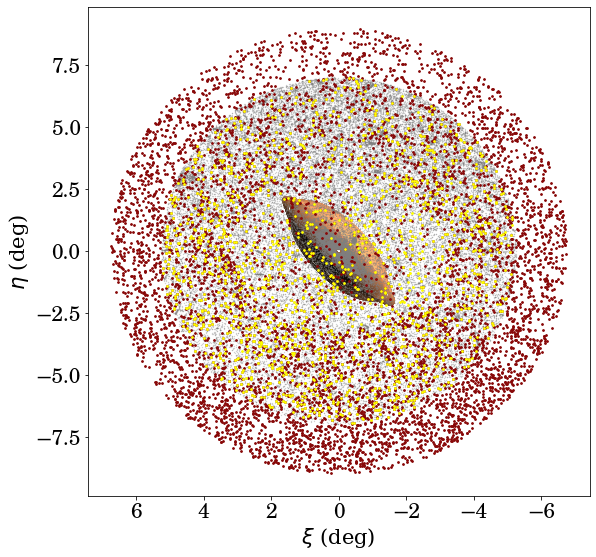

In [110]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)
plt.scatter(evt_all['RAdeg'], evt_all['DECdeg'], c='grey', s=0.1, alpha = 0.5)
plt.scatter(evt_gaia['RA_ICRS'], evt_gaia['DE_ICRS'], c='#880808', s=3)
plt.scatter(evt_cut['RAdeg'], evt_cut['DECdeg'], c='yellow', s=3)

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
#plt.xlim(-2.3, 2.3)
#plt.ylim(-2.3, 2.3)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

In [13]:
%load_ext Cython

In [14]:
%%cython
from math import pi

cdef extern from "math.h":
    double log(double)

cdef double my_log(double x):
    return log(x)

def LikelihoodCFunction(double pm_ra_quasars, double pm_dec_quasars, double mu_ra_sig_gaia, 
                        double mu_dec_sig_gaia, double mu_ra_gaia, 
                        double mu_dec_gaia):
    cdef double PreFactor, ExpRa, ExpDec

    PreFactor = 1/(2*pi*mu_ra_sig_gaia*mu_dec_sig_gaia)    
    ExpRa  = -0.5*((mu_ra_gaia - pm_ra_quasars)/(mu_ra_sig_gaia))**2
    ExpDec = -0.5*((mu_dec_gaia - pm_dec_quasars)/(mu_dec_sig_gaia))**2
    
    return my_log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)